## Use data from OEH to obtain reasonable estimates for vegetation fraction, building height, building albedo and anthropogenic heat for LCZs

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import PyQt5
import netCDF4 as nc
import numpy as np
import scipy
import os
import sys
import matplotlib
import xarray
import shapefile
import datetime as dt
import pandas as pd # For reading the csv files

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

from shapely.geometry import Point, Polygon # for the polygons within the csv files

from scipy import stats
from scipy import interpolate
import math
import scipy.io as sio

import glob as glob


## Functions

In [2]:
def plot_LCZs(data,lat,lon,mx,mn):
    # Figure formatting
    plt.rcParams['savefig.dpi']=500
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"

    # Set up projection
    plotcrs = ccrs.PlateCarree(central_longitude=150)
    gs = mpl.gridspec.GridSpec(nrows=1,ncols=1)
    fig = plt.figure(figsize=(15.0,15.0))
    ax1 = fig.add_subplot(gs[0,0],projection=plotcrs)
    cm1 = ax1.pcolormesh(lon,lat,data,vmin=mn,vmax=mx,cmap='tab20',norm=BoundaryNorm(MaxNLocator(nbins=(mx-mn+1)).tick_values(mn,mx), ncolors=plt.get_cmap('tab20').N, clip=True), transform=ccrs.PlateCarree())
    plt.colorbar(cm1)

In [3]:
from collections import Counter

def Most_Common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

In [4]:
from matplotlib import path
# The following function was found on 20.05.2019    
#https://gis.stackexchange.com/questions/71630/subsetting-a-curvilinear-netcdf-file-roms-model-output-using-a-lon-lat-boundin
def bbox2ij(lon,lat,bbox=[-160., -155., 18., 23.]):
    """Return indices for i,j that will completely cover the specified bounding box.     
    i0,i1,j0,j1 = bbox2ij(lon,lat,bbox)
    lon,lat = 2D arrays that are the target of the subset
    bbox = list containing the bounding box: [lon_min, lon_max, lat_min, lat_max]

    Example
    -------  
    >>> i0,i1,j0,j1 = bbox2ij(lon_rho,[-71, -63., 39., 46])
    >>> h_subset = nc.variables['h'][j0:j1,i0:i1]       
    """
    
    bbox=np.array(bbox)
    mypath=np.array([bbox[[0,1,1,0]],bbox[[2,2,3,3]]]).T
    p = path.Path(mypath)
    points = np.vstack((lon.flatten(),lat.flatten())).T   
    n,m = np.shape(lon)
    inside = p.contains_points(points).reshape((n,m))
    ii,jj = np.meshgrid(range(m),range(n))
    return min(ii[inside]),max(ii[inside]),min(jj[inside]),max(jj[inside])

## Read in the common inputs

In [5]:
maindir = "/g/data/w97/azh561/urban/input_parameters/"

Read in the LCZs file, for Sydney need to remove duplicated areas as we are combining two images

In [6]:
lczdir = "%s/LCZs" %(maindir)
topfilename = "%s/sydney_top.nc" %(lczdir)
botfilename = "%s/sydney_bottom.nc" %(lczdir)

# Read in the netcdf files

topfile = nc.Dataset(topfilename,'r')
topdata = topfile.variables['Band1']
toplat = topfile.variables['lat']
toplon = topfile.variables['lon']

# 1 = Dense Trees
# 2 = Sparsely Built
# 3 = Water (top data)
# 4 = Open lowrise (top data)
# 5 = Lightweight lowrise (top data)
# 6 = heavy industry (top data)
# 7 = large lowrise (top data)
# 8 = Low plants (top data)
# 9 = Scattered trees (top data)
# 10 = compact lowrise (top data)
# 11 = compact highrise (top data)
# 12 = compact midrise (top data)
# 13 = open highrise(top data)

botfile = nc.Dataset(botfilename,'r')
botdata = botfile.variables['Band1']
botlat = botfile.variables['lat']
botlon = botfile.variables['lon']

# 1 = Dense Trees
# 2 = Sparsely Built
# 3 = Low plants (bottom data)
# 4 = Scattered trees (bottom data)
# 5 = open lowrise (bottom data)
# 6 = compact lowrise (bottom data)
# 7 = lightweight lowrise (bottom data)
# 8 = heavy industry (bottom data)
# 9 = large lowrise (bottom data)
# 10 = open highrise (bottom data)
# 11 = Water (bottom data)
# 12 = Compact midrise(bottom data)
# 13 = Compact highrise (bottom data)

# Quick plot of the data to determine classifications
#plot_LCZs(np.ma.masked_where(topdata[:,:] > 1,topdata),toplat,toplon,14,0)
#plot_LCZs(np.ma.masked_where(botdata[:,:] > 1,botdata),botlat,botlon,14,0)

## Remap the Sydney maps to the following:

* 1 = Compact high-rise
* 2 = Compact midrise
* 3 = Compact lowrise
* 4 = Open high-rise
* 5 = Open mid-rise  # NOT PRESENT IN SYDNEY
* 6 = Open low-rise
* 7 = lightweight low-rise
* 8 = Large low-rise
* 9 = Sparsely built
* 10 = heavy industry

The following are vegetation classes but will be set to nan

* 11/A = Dense trees
* 12/B = Scattered trees
* 13/C Bush/scrub
* 14/D low plants
* 15/E Bare rock or paved
* 16/F Bare soil or sand
* 17/ G water

In [7]:
# Topdata total number of points: 800*962 = 769600; Nan = 314021

tmp0 = topdata[:,:]
tmp1 = np.where(tmp0==1,111,tmp0) # 1 = Dense Trees - 134288 pts
tmp2 = np.where(tmp1==2,109,tmp1) # 2 = Sparsely Built - 87466 pts
tmp3 = np.where(tmp2==3,117,tmp2) # 3 = Water (top data) - 81982
tmp4 = np.where(tmp3==4,106,tmp3) # 4 = Open lowrise (top data) - 89693
####tmp5 = np.where(tmp4==5,107,tmp4) # 5 = Lightweight lowrise (top data) - 5439
tmp5 = np.where(tmp4==5,116,tmp4) # 16/F Bare soil or sand (top data) - 5439
tmp6 = np.where(tmp5==6,110,tmp5) # 6 = heavy industry (top data) - 4956
tmp7 = np.where(tmp6==7,108,tmp6) # 7 = large lowrise (top data) - 11986
tmp8 = np.where(tmp7==8,114,tmp7) # 8 = Low plants (top data) - 12807
tmp9 = np.where(tmp8==9,112,tmp8) # 9 = Scattered trees (top data) - 7721
tmp10 = np.where(tmp9==10,103,tmp9) # 10 = compact lowrise (top data) - 17534
tmp11 = np.where(tmp10==11,101,tmp10) # 11 = compact highrise (top data) - 851
tmp12 = np.where(tmp11==12,102,tmp11) # 12 = compact midrise (top data) - 541
tmp13 = np.where(tmp12==13,104,tmp12) # 13 = open highrise(top data) - 315

newtop = np.ma.masked_where((tmp13 - 100)>100,(tmp13 - 100))

# To determine number of points in original and remapped: np.sum(np.where(topdata[:,:] == X,1,0))

#1 = Compact high-rise - 851
#2 = Compact midrise - 541
#3 = Compact lowrise - 17534
#4 = Open high-rise - 315
#5 = Open mid-rise - 0
#6 = Open low-rise - 89693
#7 = lightweight low-rise - 5439
#8 = Large low-rise - 11986
#9 = Sparsely built - 87466
#10 = heavy industry - 4956
#11/A = Dense trees - 134288
#12/B = Scattered trees - 7721
#13/C Bush/scrub - 0
#14/D low plants - 12807
#15/E Bare rock or paved - 0
#16/F Bare soil or sand - 0
#17/ G water - 81982

#plot_LCZs(newtop,toplat,toplon,17,1)

In [8]:
# Botdata total number of points: 635 * 909 = 577215; Nan = 64945

bmp0 = botdata[:,:]
bmp1 = np.where(bmp0==1,111,bmp0) # 1 = Dense Trees - 105351
bmp2 = np.where(bmp1==2,109,bmp1) # 2 = Sparsely Built - 87193
bmp3 = np.where(bmp2==3,114,bmp2) # 3 = Low plants (bottom data) - 33231
bmp4 = np.where(bmp3==4,112,bmp3) # 4 = Scattered trees (bottom data) - 33583
bmp5 = np.where(bmp4==5,106,bmp4) # 5 = open lowrise (bottom data) - 101539
bmp6 = np.where(bmp5==6,103,bmp5) # 6 = compact lowrise (bottom data) - 27816
####bmp7 = np.where(bmp6==7,107,bmp6) # 7 = lightweight lowrise (bottom data) - 5441
bmp7 = np.where(bmp6==7,116,bmp6) # 716/F Bare soil or sand (bottom data) - 5441
bmp8 = np.where(bmp7==8,110,bmp7) # 8 = heavy industry (bottom data) - 2555
bmp9 = np.where(bmp8==9,108,bmp8) # 9 = large lowrise (bottom data) - 18356
bmp10 = np.where(bmp9==10,104,bmp9) # 10 = open highrise (bottom data) - 1119
bmp11 = np.where(bmp10==11,117,bmp10) # 11 = Water (bottom data) - 94275
bmp12 = np.where(bmp11==12,102,bmp11) # 12 = Compact midrise(bottom data) - 930
bmp13 = np.where(bmp12==13,101,bmp12) # 13 = Compact highrise (bottom data) - 881

newbot = np.ma.masked_where((bmp13 - 100)>100,(bmp13 - 100))

# To determine number of points in original and remapped: np.sum(np.where(topdata[:,:] == X,1,0))

#1 = Compact high-rise - 881
#2 = Compact midrise - 930
#3 = Compact lowrise - 27816
#4 = Open high-rise - 1119
#5 = Open mid-rise - 0
#6 = Open low-rise - 101539
#7 = lightweight low-rise - 5441
#8 = Large low-rise - 18356
#9 = Sparsely built - 87193
#10 = heavy industry - 2555
#11/A = Dense trees - 105351
#12/B = Scattered trees - 33583
#13/C Bush/scrub - 0
#14/D low plants - 33231
#15/E Bare rock or paved - 0
#16/F Bare soil or sand - 0
#17/ G water - 94275

#plot_LCZs(newbot,botlat,botlon,17,1)

## Combine the Sydney top and bottom and remove duplicate points

In [9]:
# First find the grid extent
latX=np.max([np.max(toplat),np.max(botlat)])
latN=np.min([np.min(toplat),np.min(botlat)])
lonX=np.max([np.max(toplon),np.max(botlon)])
lonN=np.min([np.min(toplon),np.min(botlon)])
dlat = 0.000919 #toplat[0]-toplat[1]
dlon = 0.000919 #toplon[0]-toplon[1]

# Create new grid
lat = np.arange(latN,latX,dlat)
lon = np.arange(lonN,lonX,dlon)

# Convert lat/lon to 2D arrays
toplon2d,toplat2d = np.meshgrid(toplon,toplat)
botlon2d,botlat2d = np.meshgrid(botlon,botlat)
lon2d,lat2d = np.meshgrid(lon,lat)
coord_1di=np.vstack([lon2d.flatten(),lat2d.flatten()])
     
# Interpolate to the new grid and mask
topregrid=np.ones((lat2d.shape[0],lat2d.shape[1]))
topregrid[:,:]=scipy.interpolate.griddata((toplon2d.flatten(),toplat2d.flatten()),newtop[:,:].flatten(),coord_1di.T,method='nearest').reshape(lon2d.shape)
topma = np.ma.masked_where(topregrid>100,topregrid)
botregrid=np.ones((lat2d.shape[0],lat2d.shape[1]))
botregrid[:,:]=scipy.interpolate.griddata((botlon2d.flatten(),botlat2d.flatten()),newbot[:,:].flatten(),coord_1di.T,method='nearest').reshape(lon2d.shape)
botma = np.ma.masked_where(botregrid>100,botregrid)


Merge top and bottom

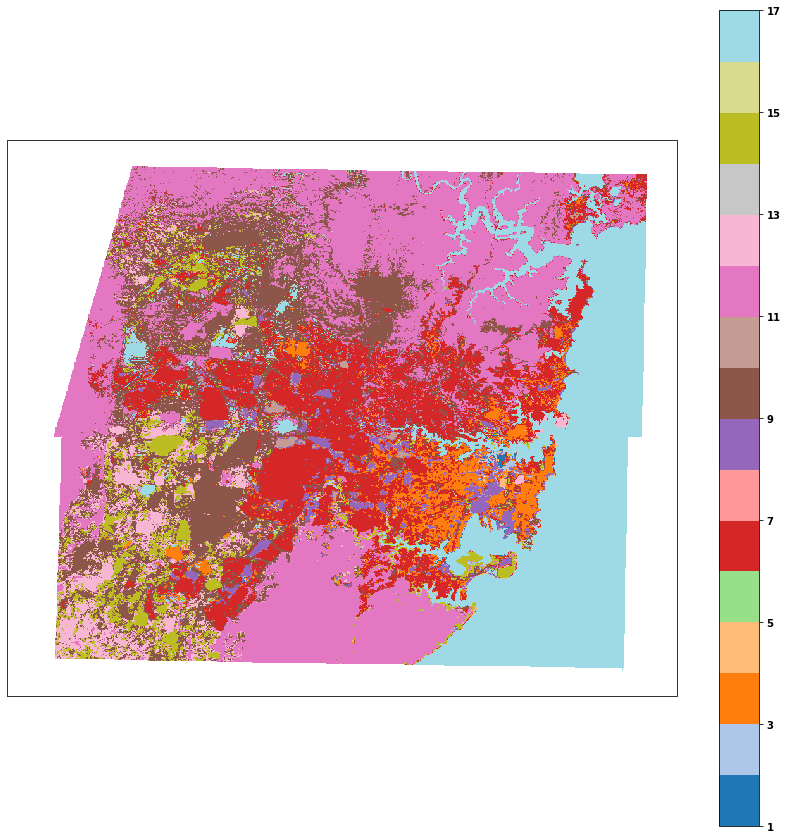

In [10]:
mergeLCZ=np.empty((lat.shape[0],lon.shape[0]))
mergeLCZ[370:,:] = topma[370:,:]
mergeLCZ[:370,:] = botma[:370,:]

mamergeLCZ=np.where(mergeLCZ>=100,np.nan,mergeLCZ)

plot_LCZs(mamergeLCZ,lat,lon,17,1)

Write new Sydney grid to netcdf

In [11]:
dataset = nc.Dataset('%s/sydney_merged.nc' %(lczdir),'w')

# Create dimensions
latitude = dataset.createDimension('latitude',lat.shape[0])
longitude = dataset.createDimension('longitude',lon.shape[0])

# Create coordinate variables
lat1d = dataset.createVariable('lat1d',np.float64,('latitude',))
lon1d = dataset.createVariable('lon1d',np.float64,('longitude',))

# Create variables
LCZ = dataset.createVariable('LCZ', np.float64,('latitude','longitude'))

# Write data
LCZ[:] = mamergeLCZ[:]
lat1d[:] = lat[:]
lon1d[:] = lon[:]

# Write the file
dataset.close()

Write new Sydney grid to text file

In [12]:
# Put all relevant variables into 1D
mergeLCZ_1di = np.vstack([lon2d.flatten(),lat2d.flatten(),mamergeLCZ.flatten()])
# mergeLCZ_1di.shape = (3, 768638)

np.savetxt('%s/sydney_merged.txt' %(lczdir), (mergeLCZ_1di.T), delimiter = ' ',header = "X Y LCZ", fmt = '%0.8f %0.8f %s')


## Get grid points corresponding to each LCZ

In [11]:
# The following creates arrays where the LCZ category is true
LCZ1 = list(np.where(mamergeLCZ.flatten() == 1)[0]) # 994
LCZ2 = list(np.where(mamergeLCZ.flatten() == 2)[0]) # 859
LCZ3 = list(np.where(mamergeLCZ.flatten() == 3)[0]) # 25401
LCZ4 = list(np.where(mamergeLCZ.flatten() == 4)[0]) # 950
LCZ5 = list(np.where(mamergeLCZ.flatten() == 5)[0]) # 0
LCZ6 = list(np.where(mamergeLCZ.flatten() == 6)[0]) # 110769
LCZ7 = list(np.where(mamergeLCZ.flatten() == 7)[0]) # 7349
LCZ8 = list(np.where(mamergeLCZ.flatten() == 8)[0]) # 17245
LCZ9 = list(np.where(mamergeLCZ.flatten() == 9)[0]) # 128645
LCZ10 = list(np.where(mamergeLCZ.flatten() == 10)[0]) # 4353

# Use poly.contains for LCZ1, LCZ2, LCZ3, LCZ4, LCZ7, LCZ8, LCZ10
# Use pt.within for LCZ6, LCZ9

In [13]:
len(LCZ1)

994

## Estimate median building height for each LCZ

In [ ]:
hobfile = '%s/dpie_building_height.csv' %(maindir)

# Column Names: LGA_CODE,LGA_NAME,SYM_CODE,MAX_B_H,UNITS,CADID,vertex_index,vertex_part,vertex_part_ring,vertex_part_index,xcoord,ycoord

hobdf = pd.read_csv(hobfile)
hob = hobdf.MAX_B_H
hoblon = hobdf.xcoord # ddd.ddddd
hoblat = hobdf.ycoord # ddd.ddddd
hobvertind = hobdf.vertex_index
hobvertind0 = list(np.where(hobvertind[:] == 0)[0])
numpoly = len(hobvertind0)
z = zip(hoblon[:],hoblat[:])
hoblonlat = [list(pair) for pair in z]

shapely.geometry has some useful features to try: https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html

- n_polygon > n_points then loop through the points and use poly.contains(pt)

- n_polygon < n_points then loop through the polygons and use pt.within(poly)


#### Using poly.contains(pt)

In [ ]:
# This methods runs faster than try to reduce the number of points
# Use poly.contains for LCZ1, LCZ2, LCZ3, LCZ4, LCZ7, LCZ8, LCZ10
LCZ9hob = np.array([])

start_time = dt.datetime.now()

#for pp in range(len(LCZ6)): 
#for pp in np.arange(0,20000,1): # hob_LCZ6_001.txt
#for pp in np.arange(20000,40000,1): # hob_LCZ6_002.txt
#for pp in np.arange(40000,60000,1): # hob_LCZ6_003.txt
#for pp in np.arange(60000,80000,1): # hob_LCZ6_004.txt
#for pp in np.arange(80000,100000,1): # hob_LCZ6_005.txt    
#for pp in np.arange(100000,110769,1): # hob_LCZ6_006.txt
#for pp in np.arange(0,25000,1): # hob_LCZ9_001.txt
#for pp in np.arange(25000,50000,1): # hob_LCZ9_002.txt
#for pp in np.arange(50000,75000,1): # hob_LCZ9_003.txt
#for pp in np.arange(75000,100000,1): # hob_LCZ9_004.txt
#for pp in np.arange(100000,125000,1): # hob_LCZ9_005.txt
for pp in np.arange(125000,128645,1): # hob_LCZ9_006.txt

    pt = Point(lon2d.flatten()[LCZ9][pp],lat2d.flatten()[LCZ9][pp])

    for ss in range(numpoly):

        if ss == numpoly-1:
            break
            
        coords = hoblonlat[hobvertind0[ss]:hobvertind0[ss+1]]
        poly = Polygon(coords)
    
        if poly.contains(pt) == True:
            LCZ9hob = np.append(LCZ9hob,hob[hobvertind0[ss]])
            break
        
        del coords,poly
        
    del pt

end_time = dt.datetime.now()
print('Duration: {}'.format(end_time - start_time))

np.savetxt('hob_LCZ9_006.txt', (LCZ9hob), delimiter = ' ', fmt = '%0.1f')

del LCZ9hob

Building Height LCZ1

In [ ]:
LCZ1hob = pd.read_csv('hob_LCZ1.txt',header=None)[0]
#[np.median(LCZ1hob), np.mean(LCZ1hob) , Most_Common(LCZ1hob), np.median(LCZ1hob[LCZ1hob>=25.]), np.mean(LCZ1hob[LCZ1hob>=25.]), Most_Common(LCZ1hob[LCZ1hob>=25.])]
#[12.0, 39.14440677966102, 8.5, 80.0, 101.77083333333333, 80.0]

# np.median(LCZ1hob[LCZ1hob>=25.]) =  80.0
# np.std(LCZ1hob[LCZ1hob>=25.]) = 67.58

Building Height LCZ2

In [ ]:
LCZ2hob = pd.read_csv('hob_LCZ2.txt',header=None)[0]
#[np.median(LCZ2hob), np.mean(LCZ2hob) , Most_Common(LCZ2hob), np.median(LCZ2hob[LCZ2hob>=10.]), np.mean(LCZ2hob[LCZ2hob>=10.]), Most_Common(LCZ2hob[LCZ2hob>=10.])]
#[12.0, 18.171693735498838, 8.5, 16.0, 23.887867647058822, 12.0]

# np.median(LCZ2hob[LCZ2hob>=10.]) = 16.0
# np.std(LCZ2hob[LCZ2hob>=10.]) = 20.96

Building Height LCZ3

In [ ]:
LCZ3hob = pd.read_csv('hob_LCZ3.txt',header=None)[0]
#[np.median(LCZ3hob), np.mean(LCZ3hob) , Most_Common(LCZ3hob), np.median(LCZ3hob[LCZ3hob<=10.]), np.mean(LCZ3hob[LCZ3hob<=10.]), Most_Common(LCZ3hob[LCZ3hob<=10.])]
# [9.0, 10.448373685497671, 8.5, 8.5, 8.816344086021505, 8.5]

# np.median(LCZ3hob[LCZ3hob<=10.]) = 8.5
# np.std(LCZ3hob[LCZ3hob<=10.]) = 0.59

Building Height LCZ4

In [ ]:
LCZ4hob = pd.read_csv('hob_LCZ4.txt',header=None)[0]
#[np.median(LCZ4hob), np.mean(LCZ4hob) , Most_Common(LCZ4hob), np.median(LCZ4hob[LCZ4hob>=25.]), np.mean(LCZ4hob[LCZ4hob>=25.]), Most_Common(LCZ4hob[LCZ4hob>=25.])]
#[13.5, 21.5621546961326, 9.0, 35.0, 48.997894736842106, 30.0]

# np.median(LCZ4hob[LCZ4hob>=25.]) = 35.0
# np.std(LCZ4hob[LCZ4hob>=25.]) = 44.46

Building Height LCZ6

In [ ]:
# To read in the file: 
LCZ6_001 = pd.read_csv('hob_LCZ6_001.txt',header=None)[0]
LCZ6_002 = pd.read_csv('hob_LCZ6_002.txt',header=None)[0]
LCZ6_003 = pd.read_csv('hob_LCZ6_003.txt',header=None)[0]
LCZ6_004 = pd.read_csv('hob_LCZ6_004.txt',header=None)[0]
LCZ6_005 = pd.read_csv('hob_LCZ6_005.txt',header=None)[0]
LCZ6_006 = pd.read_csv('hob_LCZ6_006.txt',header=None)[0]
LCZ6hob = LCZ6_001.append(LCZ6_002)
LCZ6hob = LCZ6hob.append(LCZ6_003)
LCZ6hob = LCZ6hob.append(LCZ6_004)
LCZ6hob = LCZ6hob.append(LCZ6_005)
LCZ6hob = LCZ6hob.append(LCZ6_006)

#[np.median(LCZ6hob), np.mean(LCZ6hob) , Most_Common(LCZ6hob), np.median(LCZ6hob[LCZ6hob<=10.]), np.mean(LCZ6hob[LCZ6hob<=10.]), Most_Common(LCZ6hob[LCZ6hob<=10.])]
# [9.0, 9.694770860323752, 8.5, 9.0, 8.865571028899208, 8.5]

# np.median(LCZ6hob[LCZ6hob<=10.]) = 9.0
# np.std(LCZ6hob[LCZ6hob<=10.]) = 0.54

Building Height LCZ7

In [ ]:
LCZ7hob = pd.read_csv('hob_LCZ7.txt',header=None)[0]
#[np.median(LCZ7hob), np.mean(LCZ7hob) , Most_Common(LCZ7hob), np.median(LCZ7hob[LCZ7hob<5.]), np.mean(LCZ7hob[LCZ7hob<5.]), Most_Common(LCZ7hob[LCZ7hob<5.])]
# [10.0, 11.337538580246914, 10.0, 4.0, 3.5, 4.0]

# np.median(LCZ7hob[LCZ7hob<5.]) = 4.0
# np.std(LCZ7hob[LCZ7hob<5.]) = 1.32

Building Height LCZ8

In [ ]:
LCZ8hob = pd.read_csv('hob_LCZ8.txt',header=None)[0]
#[np.median(LCZ8hob), np.mean(LCZ8hob) , Most_Common(LCZ8hob), np.median(LCZ8hob[LCZ8hob<=10.]), np.mean(LCZ8hob[LCZ8hob<=10.]), Most_Common(LCZ8hob[LCZ8hob<=10.])]
# [12.0, 18.017186488934886, 12.0, 9.0, 8.478608695652175, 8.5]

# np.median(LCZ8hob[LCZ8hob<=10.]) = 9.0
# np.std(LCZ8hob[LCZ8hob<=10.]) = 2.18

Building Height LCZ9

In [ ]:
# To read in the file: 
LCZ9_001 = pd.read_csv('hob_LCZ9_001.txt',header=None)[0]
LCZ9_002 = pd.read_csv('hob_LCZ9_002.txt',header=None)[0]
LCZ9_003 = pd.read_csv('hob_LCZ9_003.txt',header=None)[0]
LCZ9_004 = pd.read_csv('hob_LCZ9_004.txt',header=None)[0]
LCZ9_005 = pd.read_csv('hob_LCZ9_005.txt',header=None)[0]
LCZ9_006 = pd.read_csv('hob_LCZ9_006.txt',header=None)[0]
LCZ9hob = LCZ9_001.append(LCZ9_002)
LCZ9hob = LCZ9hob.append(LCZ9_003)
LCZ9hob = LCZ9hob.append(LCZ9_004)
LCZ9hob = LCZ9hob.append(LCZ9_005)
LCZ9hob = LCZ9hob.append(LCZ9_006)

#[np.median(LCZ9hob), np.mean(LCZ9hob) , Most_Common(LCZ9hob), np.median(LCZ9hob[LCZ9hob<=10.]), np.mean(LCZ9hob[LCZ9hob<=10.]), Most_Common(LCZ9hob[LCZ9hob<=10.])]
# [10.0, 10.116713796955734, 10.0, 10.0, 9.545487319997529, 10.0]

# np.median(LCZ9hob[LCZ9hob<=10.]) = 10.0
# np.std(LCZ9hob[LCZ9hob<=10.]) = 0.60

Building Height LCZ10

In [ ]:
LCZ10hob = pd.read_csv('hob_LCZ10.txt',header=None)[0]
#[np.median(LCZ10hob), np.mean(LCZ10hob) , Most_Common(LCZ10hob), np.median(LCZ10hob[LCZ10hob<=15.]), np.mean(LCZ10hob[LCZ10hob<=15.]), Most_Common(LCZ10hob[LCZ10hob<=15.])]
#[12.0, 18.703164239075843, 12.0, 11.0, 10.586800334168755, 12.0]

# np.median(LCZ10hob[LCZ10hob<=15.]) = 11.0
# np.std(LCZ10hob[LCZ10hob<=15.]) = 2.47

## Estimate the median vegetation fraction for each LCZ

In [ ]:
vffile = nc.Dataset('%s/VegCover_MMB_GSR_2016.nc' %(maindir),'r')
vf = vffile.variables['Band1'][:]

In [ ]:
from pyproj import Proj, transform

# Create lat/lon coordinates
inProj = Proj("+proj=utm +zone=56 +south +ellps=GRS80 +units=m +no_defs")
outProj = Proj('epsg:4326')

xmin = 237834.1
xmax = 346303.2
ymin = 6198129
ymax =  6316143
dxdy = 433.8764

lat1,lon1 = transform(inProj,outProj,xmin,ymax) # lon: 150.18566857987537 lat: -33.26191844972887
lat2,lon2 = transform(inProj,outProj,xmax,ymin) # lon: 151.32894056697486 lat: -34.34676997733085
lat1b,lon1b = transform(inProj,outProj,(xmin+dxdy),(ymax-dxdy)) # lon: 150.19019608390914 lat: -33.265932596537944
dx = 0.004573 #lon1b-lon1 # 0.004527504033774221 
dy = (lat1b-lat1)*-1 # -0.004014146809076635


In [ ]:
# Create new grid 
vflat = np.arange(lat2,(lat1+dy),dy)
vflon = np.arange(lon1,(lon2-dx),dx)
vflon2d,vflat2d = np.meshgrid(vflon,vflat)


In [ ]:
plot_LCZs(vf,vflat,vflon,100,1)

In [ ]:
# Regrid the vegetation fraction
vf_regrid=np.ones((lat2d.shape[0],lat2d.shape[1]))
vf_regrid[:,:]=scipy.interpolate.griddata((vflon2d.flatten(),vflat2d.flatten()),
                                              vf[:,:].flatten(),coord_1di.T,method='nearest').reshape(lon2d.shape)
vf1d = np.ma.masked_where(vf_regrid.flatten()>= 1e+20,vf_regrid.flatten())

In [ ]:
for ll in [1,2,3,4,6,7,8,9,10]:
    
    LCZ = list(np.where(mamergeLCZ.flatten() == ll)[0])
    print('Vegetation Fraction LCZ%s' %(ll))
    print(np.round(np.median(vf1d[LCZ]),1),np.round(np.mean(vf1d[LCZ]),1))
    del LCZ

Vegetation Fraction LCZ1
3.7

Vegetation Fraction LCZ2
17.8

Vegetation Fraction LCZ3
25.9

Vegetation Fraction LCZ4
8.9

Vegetation Fraction LCZ6
32.7

Vegetation Fraction LCZ7
60.4

Vegetation Fraction LCZ8
22.4

Vegetation Fraction LCZ9
73.1

Vegetation Fraction LCZ10
23.4

## Estimate median surface albedo per LCZ

In [ ]:
import glob as glob
albdir = '/g/data/u39/public/data/modis/lpdaac-mosaics-cmar/v2-nc4/aust/MCD43A3.005/'
alblist = glob.glob('%s/2016.[0-1][0-2].*/MCD43A3.2016.*.aust.005.albedo_0300_5000nm.nc' %(albdir))
nfiles = len(alblist)

# Missing value 32767
bbox = [lonN, lonX, latN, latX]

for ff in range(nfiles):
    
    albfile = nc.Dataset(alblist[ff],'r')
    
    if ff == 0:
        alblat = albfile.variables['latitude'][:]
        alblon = albfile.variables['longitude'][:]
        alblon2d,alblat2d = np.meshgrid(alblon,alblat)
        i0,i1,j0,j1 = bbox2ij(alblon2d,alblat2d,bbox)
        albedo = np.empty((nfiles,alblat[j0:j1].shape[0],alblon[i0:i1].shape[0]),dtype=np.float64)
        
    albedo[ff,:,:] = (albfile.variables['albedo_black_sky_0300_5000nm'][0,j0:j1,i0:i1] + albfile.variables['albedo_white_sky_0300_5000nm'][0,j0:j1,i0:i1]) / 2.
    
    albfile.close()
    
albedo_ma = np.ma.masked_where(albedo == 32767.,albedo)

In [ ]:
albmax = np.nanmax(albedo_ma,axis=0)
albmin = np.nanmin(albedo_ma,axis=0)
albavg = np.nanmean(albedo_ma,axis=0)

# Regrid the albedo
albmax_regrid=np.ones((lat2d.shape[0],lat2d.shape[1]))
albmax_regrid[:,:]=scipy.interpolate.griddata((alblon2d[j0:j1,i0:i1].flatten(),alblat2d[j0:j1,i0:i1].flatten()),
                                              albmax[:,:].flatten(),coord_1di.T,method='nearest').reshape(lon2d.shape)
albmax1d = albmax_regrid.flatten()

albmin_regrid=np.ones((lat2d.shape[0],lat2d.shape[1]))
albmin_regrid[:,:]=scipy.interpolate.griddata((alblon2d[j0:j1,i0:i1].flatten(),alblat2d[j0:j1,i0:i1].flatten()),
                                              albmin[:,:].flatten(),coord_1di.T,method='nearest').reshape(lon2d.shape)
albmin1d = albmin_regrid.flatten()

albavg_regrid=np.ones((lat2d.shape[0],lat2d.shape[1]))
albavg_regrid[:,:]=scipy.interpolate.griddata((alblon2d[j0:j1,i0:i1].flatten(),alblat2d[j0:j1,i0:i1].flatten()),
                                              albavg[:,:].flatten(),coord_1di.T,method='nearest').reshape(lon2d.shape)
albavg1d = albavg_regrid.flatten()

In [ ]:
for ll in np.arange(1,11,1):
    
    LCZ = list(np.where(mamergeLCZ.flatten() == ll)[0])
    print('Albedo LCZ%s' %(ll))
    print([np.round(np.median(albmin1d[LCZ]),3), np.round(np.mean(albmin1d[LCZ]),3),
           np.round(np.median(albavg1d[LCZ]),3), np.round(np.mean(albavg1d[LCZ]),3), 
           np.round(np.median(albmax1d[LCZ]),3), np.round(np.mean(albmax1d[LCZ]),3)])
    del LCZ


Albedo LCZ X [median(min) mean(min) median(avg) mean(avg) median(max) mean(max)]

Albedo LCZ1
[0.076, 0.076, 0.089, 0.089, 0.107, 0.104]

Albedo LCZ2
[0.11, 0.101, 0.12, 0.113, 0.134, 0.128]

Albedo LCZ3
[0.125, 0.12, 0.134, 0.131, 0.146, 0.145]

Albedo LCZ4
[0.104, 0.098, 0.115, 0.11, 0.134, 0.125]

Albedo LCZ5
[nan, nan, nan, nan, nan, nan]

Albedo LCZ6
[0.124, 0.121, 0.135, 0.131, 0.148, 0.146]

Albedo LCZ7
[0.132, 0.124, 0.146, 0.137, 0.16, 0.153]

Albedo LCZ8
[0.133, 0.13, 0.145, 0.142, 0.158, 0.156]

Albedo LCZ9
[0.129, 0.128, 0.142, 0.14, 0.156, 0.155]

Albedo LCZ10
[0.135, 0.135, 0.147, 0.147, 0.161, 0.162]



## Estimate for anthropogenic heat

See http://www.sciencedirect.com/science/article/pii/S1352231016309232 and access data via http://www.ide.titech.ac.jp/~kandalab/ja/news/2016/AHE_release_20161212_files/AHE_release_20161212.htm

Corner Coordinates:

- Upper Left  ( 150.3750000, -33.0291661) (150d22'30.00"E, 33d 1'45.00"S)

- Lower Left  ( 150.3750000, -34.6958328) (150d22'30.00"E, 34d41'45.00"S)

- Upper Right ( 152.0416667, -33.0291661) (152d 2'30.00"E, 33d 1'45.00"S)

- Lower Right ( 152.0416667, -34.6958328) (152d 2'30.00"E, 34d41'45.00"S)


In [ ]:
from PIL import Image

heatdir = '/g/data/w97/azh561/urban/input_parameters/energy_use/sydney/'
#heatlist = glob.glob('%s/???_ahe_[0-9][0-9]_trimmed.tif' %(heatdir))
heatlist = glob.glob('%s/dec_ahe_[0-9][0-9]_trimmed.tif' %(heatdir))
janlist = glob.glob('%s/jan_ahe_[0-9][0-9]_trimmed.tif' %(heatdir))
feblist = glob.glob('%s/feb_ahe_[0-9][0-9]_trimmed.tif' %(heatdir))
heatlist = np.append(heatlist,janlist)
heatlist = np.append(heatlist,feblist)
nfiles = len(heatlist) # 288 ANN # 72 for DJF

for ff in range(nfiles):
    
    im = np.array(Image.open(heatlist[ff]))
    
    if ff == 0:
        heat = np.empty((nfiles,im.shape[0],im.shape[1]),dtype=np.float64) # [288, 200, 200]
        
    heat[ff,:,:] = im
    
    del im
    
heat_ma = np.ma.masked_where(heat < 0., heat)

In [ ]:
# Create new grid - original on 30 arc-minute resolution
heatlat = np.arange(-34.6958328,-33.0374993,0.0083333)
heatlon = np.arange(150.3750000,152.0333334,0.0083333)
heatlon2d,heatlat2d = np.meshgrid(heatlon,heatlat)

heatmax = np.nanmax(heat_ma,axis=0)
heatmin = np.nanmin(heat_ma,axis=0)
heatmed = np.median(heat_ma,axis=0)

# Regrid the anthropogenic heat
heatmax_regrid=np.ones((lat2d.shape[0],lat2d.shape[1]))
heatmax_regrid[:,:]=scipy.interpolate.griddata((heatlon2d.flatten(),heatlat2d.flatten()),
                                              heatmax[:,:].flatten(),coord_1di.T,method='nearest').reshape(lon2d.shape)
heatmax1d = np.ma.masked_where(heatmax_regrid.flatten()>= 1e+20,heatmax_regrid.flatten())

heatmin_regrid=np.ones((lat2d.shape[0],lat2d.shape[1]))
heatmin_regrid[:,:]=scipy.interpolate.griddata((heatlon2d.flatten(),heatlat2d.flatten()),
                                              heatmin[:,:].flatten(),coord_1di.T,method='nearest').reshape(lon2d.shape)
heatmin1d = np.ma.masked_where(heatmin_regrid.flatten()>= 1e+20,heatmin_regrid.flatten())

heatmed_regrid=np.ones((lat2d.shape[0],lat2d.shape[1]))
heatmed_regrid[:,:]=scipy.interpolate.griddata((heatlon2d.flatten(),heatlat2d.flatten()),
                                              heatmed[:,:].flatten(),coord_1di.T,method='nearest').reshape(lon2d.shape)
heatmed1d = np.ma.masked_where(heatmed_regrid.flatten()>= 1e+20,heatmed_regrid.flatten())



In [ ]:
for ll in [1,2,3,4,6,7,8,9,10]:
    
    LCZ = list(np.where(mamergeLCZ.flatten() == ll)[0])
    print('Anthropogenic Heat LCZ%s' %(ll))
    print([np.round(np.median(heatmin1d[LCZ]),1), np.round(np.mean(heatmin1d[LCZ]),1), np.round(np.max(heatmin1d[LCZ]),1),
           np.round(np.median(heatmed1d[LCZ]),1), np.round(np.mean(heatmed1d[LCZ]),1), np.round(np.max(heatmed1d[LCZ]),1),
           np.round(np.median(heatmax1d[LCZ]),1), np.round(np.mean(heatmax1d[LCZ]),1), np.round(np.max(heatmax1d[LCZ]),1)])
    del LCZ


Anthropogenic Heat LCZ X [median(min) mean(min) max(min) median(avg) mean(avg) max(avg) median(max) mean(max) max(max)]

Anthropogenic Heat LCZ1
[2.6, 3.3, 15.4, 5.9, 9.9, 54.0, 16.2, 20.3, 95.0]

Anthropogenic Heat LCZ2
[2.7, 3.3, 15.4, 5.3, 9.5, 54.0, 16.8, 20.1, 95.0]

Anthropogenic Heat LCZ3
[1.8, 2.0, 15.4, 5.2, 6.6, 54.0, 11.2, 12.4, 95.0]

Anthropogenic Heat LCZ4
[2.6, 2.9, 15.4, 6.5, 9.2, 54.0, 16.3, 17.7, 95.0]

Anthropogenic Heat LCZ6
[1.5, 1.7, 15.4, 2.7, 5.5, 54.0, 9.4, 10.5, 95.0]

Anthropogenic Heat LCZ7
[0.1, 0.9, 12.1, 0.2, 3.0, 42.5, 0.4, 5.4, 74.8]

Anthropogenic Heat LCZ8
[1.7, 1.9, 15.4, 5.1, 6.5, 54.0, 10.7, 11.7, 95.0]

Anthropogenic Heat LCZ9
[0.1, 0.6, 9.2, 0.2, 2.0, 33.7, 0.4, 3.6, 56.7]

Anthropogenic Heat LCZ10
[1.9, 1.9, 10.4, 5.6, 6.5, 36.3, 11.4, 11.8, 63.9]